In [39]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

In [40]:
import split_folders

#split_folders.ratio('Image_data', output="output", seed=1337, ratio=(.8, .1, .1))

In [41]:
#Default dimensions we found online
img_width, img_height = 224, 224 
 
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5'
 
# loading up our datasets
train_data_dir = 'output/train' 
validation_data_dir = 'output/val' 
test_data_dir = 'output/test'

# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 50 

In [42]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

datagen = ImageDataGenerator(rescale=1. / 255) 
#needed to create the bottleneck .npy files

In [43]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train) 
 
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1074 images belonging to 5 classes.
Time:  0:04:07.154608


In [44]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_validation_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size)) 
 
bottleneck_features_validation = vgg16.predict_generator(generator, predict_size_validation) 
 
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 159 images belonging to 5 classes.
Time:  0:00:38.804719


In [45]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    test_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_test_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_test = int(math.ceil(nb_test_samples / batch_size)) 
 
bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test) 
 
np.save('bottleneck_features_test.npy', bottleneck_features_test)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 172 images belonging to 5 classes.
Time:  0:00:42.341690


In [46]:
#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load('bottleneck_features_train.npy') 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 1074 images belonging to 5 classes.


In [47]:
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy', allow_pickle=True)  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 159 images belonging to 5 classes.


In [48]:
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 172 images belonging to 5 classes.


In [49]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer='rmsprop',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=5,  
      batch_size=batch_size,  
      validation_data=[validation_data,validation_labels])  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 1074 samples, validate on 159 samples
Epoch 1/5
1074/1074 [==============================] - 2s 2ms/step - loss: 6.4076 - acc: 0.3892 - val_loss: 1.0559 - val_acc: 0.7358
Epoch 2/5
1074/1074 [==============================] - 1s 1ms/step - loss: 1.0270 - acc: 0.6955 - val_loss: 0.6600 - val_acc: 0.7862
Epoch 3/5
1074/1074 [==============================] - 1s 972us/step - loss: 0.5927 - acc: 0.7896 - val_loss: 0.8683 - val_acc: 0.7610
Epoch 4/5
1074/1074 [==============================] - 1s 980us/step - loss: 0.6195 - acc: 0.7961 - val_loss: 0.4149 - val_acc: 0.8742
Epoch 5/5
159/159 [==============================] - 0s 282us/step
[INFO] accuracy: 88.68%
[INFO] Loss: 0.32851420848999385
Time:  0:00:06.759987


In [50]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation='relu'))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 1074 samples, validate on 159 samples
Epoch 1/7
1074/1074 [==============================] - 1s 913us/step - loss: 1.4543 - acc: 0.3799 - val_loss: 1.0440 - val_acc: 0.7547
Epoch 2/7
1074/1074 [==============================] - 0s 437us/step - loss: 1.1122 - acc: 0.5568 - val_loss: 0.8532 - val_acc: 0.7233
Epoch 3/7
1074/1074 [==============================] - 0s 426us/step - loss: 0.9545 - acc: 0.6453 - val_loss: 0.6846 - val_acc: 0.8491
Epoch 4/7
1074/1074 [==============================] - 0s 427us/step - loss: 0.8683 - acc: 0.6909 - val_loss: 0.6609 - val_acc: 0.7484
Epoch 5/7
1074/1074 [==============================] - 0s 433us/step - loss: 0.7541 - acc: 0.7365 - val_loss: 0.5020 - val_acc: 0.8491
Epoch 6/7
1074/1074 [==============================] - 0s 422us/step - loss: 0.7180 - acc: 0.7495 - val_loss: 0.4902 - val_acc: 0.8616
Epoch 7/7
159/159 [==============================] - 0s 148us/step
[INFO] accuracy: 89.94%
[INFO] Loss: 0.41280183477221793
Time:  0:00:04.5014

In [51]:
import keras
from keras import optimizers
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

/Users/jas10022/anaconda3/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 1074 samples, validate on 159 samples
Epoch 1/7
1074/1074 [==============================] - 1s 931us/step - loss: 1.3310 - acc: 0.4739 - val_loss: 0.7795 - val_acc: 0.7484
Epoch 2/7
1074/1074 [==============================] - 0s 428us/step - loss: 0.7893 - acc: 0.7123 - val_loss: 0.5927 - val_acc: 0.8239
Epoch 3/7
1074/1074 [==============================] - 0s 426us/step - loss: 0.6663 - acc: 0.7588 - val_loss: 0.5167 - val_acc: 0.8365
Epoch 4/7
1074/1074 [==============================] - 0s 433us/step - loss: 0.5224 - acc: 0.8231 - val_loss: 0.5275 - val_acc: 0.7987
Epoch 5/7
1074/1074 [==============================] - ETA: 0s - loss: 0.4935 - acc: 0.837 - 0s 428us/step - loss: 0.4915 - acc: 0.8380 - val_loss: 0.3577 - val_acc: 0.9119
Epoch 6/7
1074/1074 [==============================] - 0s 444us/step - loss: 0.4041 - acc: 0.8724 - val_loss: 0.3395 - val_acc: 0.8994
Epoch 7/7
159/159 [==============================] - 0s 126us/step
[INFO] accuracy: 91.82%
[INFO] Loss: 0

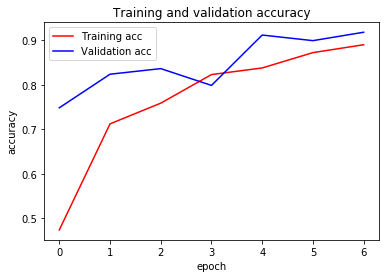

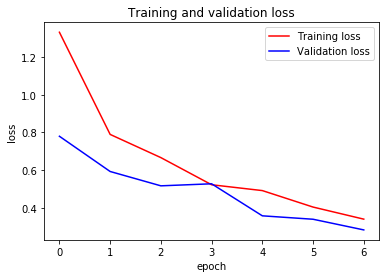

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               2508900   
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 255       
Total params: 2,514,205
Trainable params: 2,514,205
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.evaluate(test_data, test_labels)

172/172 [==============================] - 0s 391us/step


[0.3296557720317397, 0.8720930218696594]

In [55]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
preds = np.round(model.predict(test_data),0)
classification_metrics = metrics.classification_report(test_labels, preds)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.97      0.81      0.89        48
           1       0.86      0.81      0.83        31
           2       0.89      0.83      0.86        30
           3       0.91      0.94      0.93        34
           4       0.92      0.83      0.87        29

   micro avg       0.92      0.84      0.88       172
   macro avg       0.91      0.84      0.88       172
weighted avg       0.92      0.84      0.88       172
 samples avg       0.84      0.84      0.84       172



/Users/jas10022/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [56]:
test_labels_tentative = pd.DataFrame(test_labels).idxmax(axis=1)
preds_tentative = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(test_labels_tentative, preds_tentative)
confusion_matrix

array([[42,  4,  0,  1,  1],
       [ 4, 25,  1,  0,  1],
       [ 4,  0, 25,  1,  0],
       [ 1,  0,  1, 32,  0],
       [ 3,  0,  1,  1, 24]])

In [57]:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


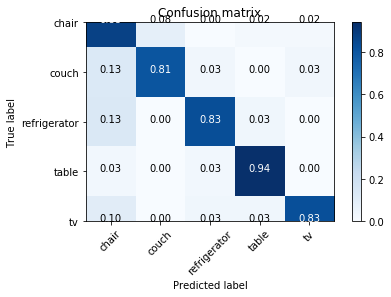

In [58]:
import itertools
listItems = ['chair','couch','refrigerator','table','tv']
plot_confusion_matrix(confusion_matrix, 
                      listItems,
                     normalize=True)

In [59]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(200, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu')) 
model.add(Dropout(0.6))
model.add(Dense(50, activation='relu'))  
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer='rmsprop',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=20,  
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 1074 samples, validate on 159 samples
Epoch 1/20
1074/1074 [==============================] - 2s 1ms/step - loss: 3.0338 - acc: 0.2663 - val_loss: 1.3210 - val_acc: 0.4654
Epoch 2/20
1074/1074 [==============================] - 1s 795us/step - loss: 1.5142 - acc: 0.3883 - val_loss: 1.2158 - val_acc: 0.4654
Epoch 3/20
1074/1074 [==============================] - 1s 794us/step - loss: 1.3332 - acc: 0.4581 - val_loss: 1.1088 - val_acc: 0.5723
Epoch 4/20
1074/1074 [==============================] - 1s 801us/step - loss: 1.1547 - acc: 0.5307 - val_loss: 1.0462 - val_acc: 0.5849
Epoch 5/20
1074/1074 [==============================] - 1s 794us/step - loss: 1.0257 - acc: 0.6108 - val_loss: 0.6265 - val_acc: 0.8050
Epoch 6/20
1074/1074 [==============================] - 1s 795us/step - loss: 0.8668 - acc: 0.6555 - val_loss: 0.6441 - val_acc: 0.7736
Epoch 7/20
1074/1074 [==============================] - 1s 805us/step - loss: 0.7753 - acc: 0.7067 - val_loss: 0.5680 - val_acc: 0.8113
Epo

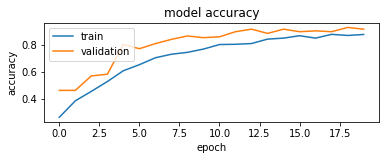

In [60]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')

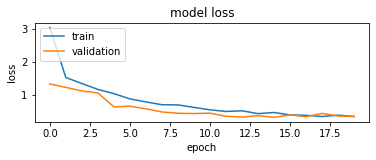

In [61]:

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()

In [62]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [63]:
from keras import backend as K
import tensorflow as tf

# Create, compile and train model...

#frozen_graph = freeze_session(K.get_session(),
#                              output_names=[out.op.name for out in model.outputs])

In [64]:
#tf.train.write_graph(frozen_graph, ".", "my_model.pb", as_text=False)

In [65]:
#import coremltools
#coreml_model = coremltools.converters.keras.convert(model,
#	input_names="image",
#	image_input_names="image",
#	image_scale=1/255.0,
#	class_labels=listItems)

In [66]:
from keras.models import Model
fullModel = Model(inputs=vgg16.input, outputs=model(vgg16.output))  

In [68]:
import coremltools
coreml_model = coremltools.converters.keras.convert(fullModel,
	input_names="image",
	image_input_names="image",
	image_scale=1/255.0,
	class_labels=listItems)

0 : input_2, <keras.engine.input_layer.InputLayer object at 0x1a45966358>
1 : block1_conv1, <keras.layers.convolutional.Conv2D object at 0x1a4467d710>
2 : block1_conv1__activation__, <keras.layers.core.Activation object at 0x1a397e0a58>
3 : block1_conv2, <keras.layers.convolutional.Conv2D object at 0x1a3ece94e0>
4 : block1_conv2__activation__, <keras.layers.core.Activation object at 0x1a397e0940>
5 : block1_pool, <keras.layers.pooling.MaxPooling2D object at 0x1a446decc0>
6 : block2_conv1, <keras.layers.convolutional.Conv2D object at 0x1a3ed02b38>
7 : block2_conv1__activation__, <keras.layers.core.Activation object at 0x1a397e0a90>
8 : block2_conv2, <keras.layers.convolutional.Conv2D object at 0x1a446cdda0>
9 : block2_conv2__activation__, <keras.layers.core.Activation object at 0x1a397e02e8>
10 : block2_pool, <keras.layers.pooling.MaxPooling2D object at 0x1a3eaeac50>
11 : block3_conv1, <keras.layers.convolutional.Conv2D object at 0x1a45972a58>
12 : block3_conv1__activation__, <keras.lay

In [69]:
output = fullModel.rsplit(".", 1)[0] + ".mlmodel"

AttributeError: 'Model' object has no attribute 'rsplit'

In [70]:
coreml_model.save("my_model.mlmodel")